# RP 01 - Binary Sequences
Predict next binary value, given a sequence (fixed or variable lenght).
- Better: give the probability of a "1".
- Example scenario: given past purchases over N weeks, give a probability that a given customer will buy product Y in the next week.
  - Extend to multiple customers and products.
  - Given a customer and the probabilities of her/him buying RP products in the next week, provide a ranked list of recommendations.

In [1]:
from __future__ import absolute_import, division, print_function
import os, sys, time
import numpy as np
import pandas as pd
import tensorflow as tf
from tqdm import tnrange, tqdm_notebook

sys.path.append(os.environ['HOME'] + "/ninja/mxn/src/MxnVentures")
from mxn_ventures import utils

%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


## Fixed Length RP Binary Buy/No-Buy Sequences Prediction

In [102]:
etl_run_date = "20161001"
min_cust = 10
min_orders_per_cust = 2
n_weeks = 92
n_products = 100

HOME = os.environ['HOME']
dpath = HOME + "/data/b2b/orders/" + etl_run_date
fname_ppw_seqs = dpath + "/ppw/rp_cust{}_ord{}_ppw{}".format(min_cust, min_orders_per_cust, n_weeks) + "_seq{:04}.txt"
fname_upw_seqs = dpath + "/ppw/rp_cust{}_ord{}_upw{}".format(min_cust, min_orders_per_cust, n_weeks) + "_seq{:04}.txt"

log_path = dpath + "/ppw/logs"
if not os.path.exists(log_path):
    os.makedirs(log_path)

### Functions to Read, get Info, and Visualize UPW Seqs Data

In [70]:
def read_upw_seq(i, make_binary=True):
    filename = fname_upw_seqs.format(i)
    with open(filename, 'r') as inp:
        orders = np.array([line.strip().split() for line in inp]).astype(int)
    if make_binary:
        orders = orders >= 1
    return orders
def flatten_list(l):
    return [a for b in l for a in b]
def upw_seqs_info(seqs):
    """Basic info on upw seqs for a single product."""
    print("Number of customers: {}   and weeks: {}".format(*seqs.shape))
    dt = []
    for s in seqs:
        x = np.where(s>0)[0]
        if len(x) <= 1:
            dt.append([])
        else:
            dt.append(x[1:]-x[:-1])
    print("Number of customers with insufficient dt: {}".format(len([1 for x in dt if len(x)<1])))
    print("Number of orders per customers stats    : {}".format(utils.stats_str([sum(x>0) for x in seqs], with_median=True)))
    print("dt stats                       (|dt|>=1): {}".format(utils.stats_str(flatten_list([x for x in dt if len(x)>=1]), with_median=True)))
def upw_seqs_show(seqs):
    plt.figure(figsize=(17,13))
    plt.subplot(221)
    for i in range(10):
        plt.plot(seqs[i], label="Cust {}: {} orders".format(i, sum(seqs[i]>0))); # show only first 10 for reference
    plt.xlim(0,len(seqs[0]))
    plt.legend(loc="best", fontsize=8)
    plt.subplot(222)
    plt.imshow(np.array(seqs), interpolation='nearest', aspect='auto')
    

In [71]:
seqs = read_upw_seq(0, make_binary=True)

In [72]:
upw_seqs_info(seqs)

Number of customers: 2910   and weeks: 92
Number of customers with insufficient dt: 792
Number of orders per customers stats    : 4.158 ±6.158 [0..90] median: 2.000
dt stats                       (|dt|>=1): 6.197 ±12.170 [1..91] median: 2.000


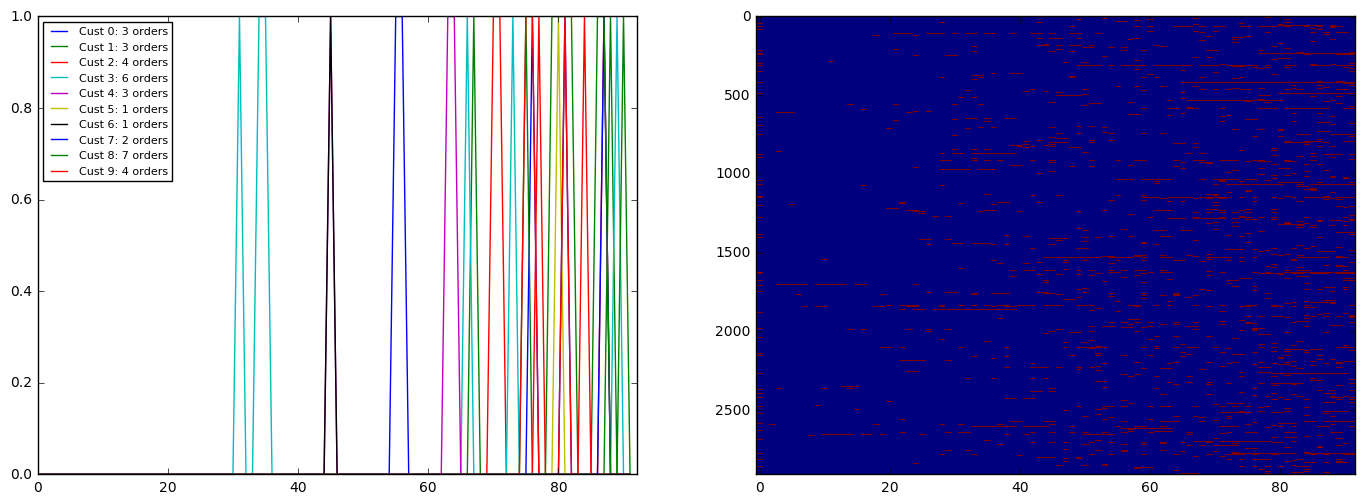

In [73]:
upw_seqs_show(seqs)

# TensorFlow Binary Seqs Learning

In [74]:
def get_batch(seqs, batch_size):
    n_batches = len(seqs) // batch_size
    for i in range(n_batches):
        # yield seqs[i*batch_size:(i+1)*batch_size]
        x = seqs[i*batch_size:(i+1)*batch_size, :-1]
        y = seqs[i*batch_size:(i+1)*batch_size, 1:]
        yield x, y
def get_epochs(seqs, n_epochs, batch_size=200, shuffle=True):
    for i in range(n_epochs):
        if shuffle:
            seqs = np.random.permutation(seqs)
        yield get_batch(seqs, batch_size)

## Model

Ideas:
- non-uniform loss weighting: increase weights for y>0, to increase priority of order weeks

In [125]:
num_steps = n_weeks - 1
num_classes = 2
batch_size = 10 # 100
n_epochs = 5

learning_rate = 0.01
state_size = 100

In [126]:
tf.reset_default_graph()

### Placeholders
with tf.name_scope("Inputs"):
    x = tf.placeholder(tf.int32, [batch_size, num_steps], name='input_x')
    y = tf.placeholder(tf.int32, [batch_size, num_steps], name='labels_y')
    init_state = tf.zeros([batch_size, state_size])

### Inputs
    x_one_hot = tf.one_hot(x, num_classes)
    rnn_inputs = tf.unpack(x_one_hot, axis=1)

In [127]:
### RNN

# changing this turns out to be problematic - take care with this

with tf.name_scope("Cells"):
    cell = tf.nn.rnn_cell.BasicRNNCell(state_size)
    rnn_outputs, final_state = tf.nn.rnn(cell, rnn_inputs, initial_state=init_state)
#     cell = tf.nn.rnn_cell.BasicLSTNCell(state_size)
#     cell = tf.nn.rnn_cell.GRUCell(state_size)
#     rnn_outputs, final_state = tf.nn.dynamic_rnn(cell, rnn_inputs, initial_state=init_state)

In [128]:
### Predictions, loss, training step
with tf.variable_scope('softmax'):
    W = tf.get_variable('W', [state_size, num_classes])
    b = tf.get_variable('b', [num_classes], initializer=tf.constant_initializer(0.0))
with tf.name_scope("Softmax"):
    logits = [tf.matmul(rnn_output, W) + b for rnn_output in rnn_outputs]
#with tf.name_scope("Predictions"):
    predictions = [tf.nn.softmax(logit) for logit in logits]

y_as_list = [tf.squeeze(i, squeeze_dims=[1]) for i in tf.split(1, num_steps, y)]

### One Could increase Loss Weighting for y > 0, ie. to force it to learn the non-zero purchases better!

with tf.name_scope("Loss"):
    loss_weights = [tf.ones([batch_size]) for i in range(num_steps)]
    losses = tf.nn.seq2seq.sequence_loss_by_example(logits, y_as_list, loss_weights)
    total_loss = tf.reduce_mean(losses)
with tf.name_scope("Train"):
    train_step = tf.train.AdagradOptimizer(learning_rate).minimize(total_loss)

### Logging Summaries

In [129]:
#### for cost and accuracy:
tf.scalar_summary("loss", total_loss)
#tf.scalar_summary("accuracy", accuracy)

#### for data distributions:
w_h = tf.histogram_summary("weights", W)
b_h = tf.histogram_summary("biases", b)

tf.histogram_summary("logits", logits)
tf.histogram_summary("predictions", predictions)
tf.histogram_summary("losses", losses)


#### merge all summaries into a single "operation" which we can execute in a session 
summary_op = tf.merge_all_summaries()

### Training

In [130]:
def train_network(num_epochs, num_steps, state_size=4, verbose=True):
    with tf.Session() as sess:
        sess.run(tf.initialize_all_variables())
        writer = tf.train.SummaryWriter(log_path, graph=tf.get_default_graph())
        training_losses = []
        n_eval_steps = 10
        ii = 0
#         for idx, epoch in enumerate(gen_epochs(num_epochs, num_steps, batch_size, model_func=data_model_func)):
        for idx, epoch in enumerate(get_epochs(seqs, num_epochs, batch_size)):
            training_loss = 0
            training_state = np.zeros((batch_size, state_size))
            if verbose:
                print("\nEPOCH", idx)
            for step, (X, Y) in enumerate(epoch):
                tr_losses, training_loss_, training_state, _, summary = sess.run(
                    [losses, total_loss, final_state, train_step, summary_op],
                    feed_dict={x:X, y:Y, init_state:training_state})
                training_loss += training_loss_
                ii += 1
                writer.add_summary(summary, ii)
                if step % n_eval_steps == 0 and step > 0:
                    if verbose:
                        print("Average loss at step {} for last {} steps: {}".format(step, n_eval_steps, training_loss/n_eval_steps))
                    training_losses.append(training_loss/n_eval_steps)
                    training_loss = 0
                
    return training_losses


EPOCH 0
Average loss at step 10 for last 10 steps: 0.3188234940171242
Average loss at step 20 for last 10 steps: 0.16715070754289627
Average loss at step 30 for last 10 steps: 0.17125560641288756
Average loss at step 40 for last 10 steps: 0.15555564016103746
Average loss at step 50 for last 10 steps: 0.14530637487769127
Average loss at step 60 for last 10 steps: 0.15956686362624167
Average loss at step 70 for last 10 steps: 0.16351554840803145
Average loss at step 80 for last 10 steps: 0.15265912115573882
Average loss at step 90 for last 10 steps: 0.1732213504612446
Average loss at step 100 for last 10 steps: 0.14592029750347138
Average loss at step 110 for last 10 steps: 0.16023534685373306
Average loss at step 120 for last 10 steps: 0.13749515563249587
Average loss at step 130 for last 10 steps: 0.1490183487534523
Average loss at step 140 for last 10 steps: 0.13424963057041167
Average loss at step 150 for last 10 steps: 0.14545329585671424
Average loss at step 160 for last 10 steps:

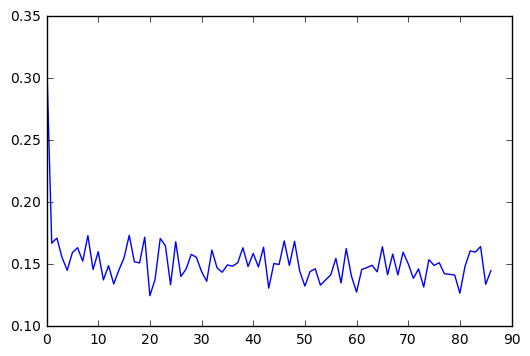

In [131]:
training_losses = train_network(3, num_steps, state_size=state_size)
plt.plot(training_losses)